In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Task 1 : Select what features you'll use.

In [2]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'exercised_stock_options', 'bonus', 'loan_advances','expenses', 'poi_message_percentage']
                    # 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi']

# You will need to use more features
# 认为POI都是收入水平很高，且需要花钱的人，因此加入税金与可行驶的股票期权

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


C:\Users\dtzyh\Anaconda3\envs\ml\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Task 1.1 : Explore dataset.

In [3]:
print 'Originally, number of data points is {0}'.format(len(data_dict))

Originally, number of data points is 146


In [4]:
poi_list = {name:info for name,info in data_dict.iteritems() if info['poi']==1}
print 'POI number is {0}'.format(len(poi_list))
print 'Not POI number is {0}'.format(len({name:info for name,info in data_dict.iteritems() if info['poi']==0}))

POI number is 18
Not POI number is 128


In [5]:
print 'Features number is {0}'.format(len(features_list))
print

for feature in features_list:
    feature_nan_list = [info[feature] for name, info in data_dict.iteritems() if feature in info.keys() and info[feature] == 'NaN']
    print "NaN number of feature : {0} : {1}".format(feature, len(feature_nan_list),)
print 

for feature in features_list:
    poi_list_with_feature_nan = [info[feature] for poi, info in poi_list.iteritems() if feature in info.keys() and  info[feature] == 'NaN']
    print "poi with NaN {0} value / total poi number : {1} / {2}".format(feature, len(poi_list_with_feature_nan), len(poi_list))

Features number is 7

NaN number of feature : poi : 0
NaN number of feature : salary : 51
NaN number of feature : exercised_stock_options : 44
NaN number of feature : bonus : 64
NaN number of feature : loan_advances : 142
NaN number of feature : expenses : 51
NaN number of feature : poi_message_percentage : 0

poi with NaN poi value / total poi number : 0 / 18
poi with NaN salary value / total poi number : 1 / 18
poi with NaN exercised_stock_options value / total poi number : 6 / 18
poi with NaN bonus value / total poi number : 2 / 18
poi with NaN loan_advances value / total poi number : 17 / 18
poi with NaN expenses value / total poi number : 0 / 18
poi with NaN poi_message_percentage value / total poi number : 0 / 18


# Task 2: Remove outliers

In [6]:
### Task 2: Remove outliers
data_dict.pop( 'TOTAL', 0 ) # TOTAL 存储的是所有人的总和，因此为异常值

print 'After removing outliers, new number of data point is {0}'.format(len(data_dict))

After removing outliers, new number of data point is 145


# Task 3: Create new feature(s)

In [7]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

for k,v in my_dataset.iteritems():
    to_messages = v['to_messages'] 
    from_poi_to_this_person = v['from_poi_to_this_person']
    from_messages = v['from_messages']
    from_this_person_to_poi = v['from_this_person_to_poi']

    if to_messages == 'NaN' or from_poi_to_this_person == 'NaN' or from_messages == 'NaN' or from_this_person_to_poi == 'NaN':
        v['poi_message_percentage'] = 'NaN'
        continue
    
    poi_message_percentage = 1.0*(from_poi_to_this_person + from_this_person_to_poi) / (to_messages + from_messages)
    v['poi_message_percentage'] = poi_message_percentage
    #print poi_message_percentage

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [8]:
### my code
print features_list

['poi', 'salary', 'exercised_stock_options', 'bonus', 'loan_advances', 'expenses', 'poi_message_percentage']


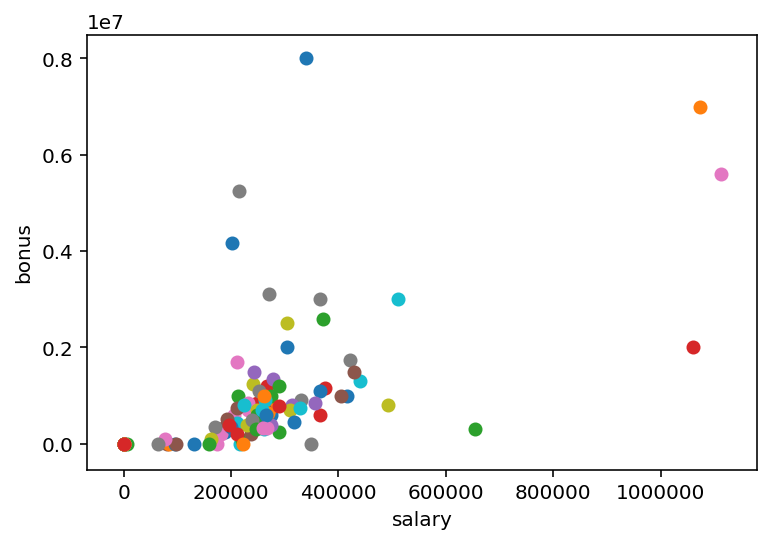

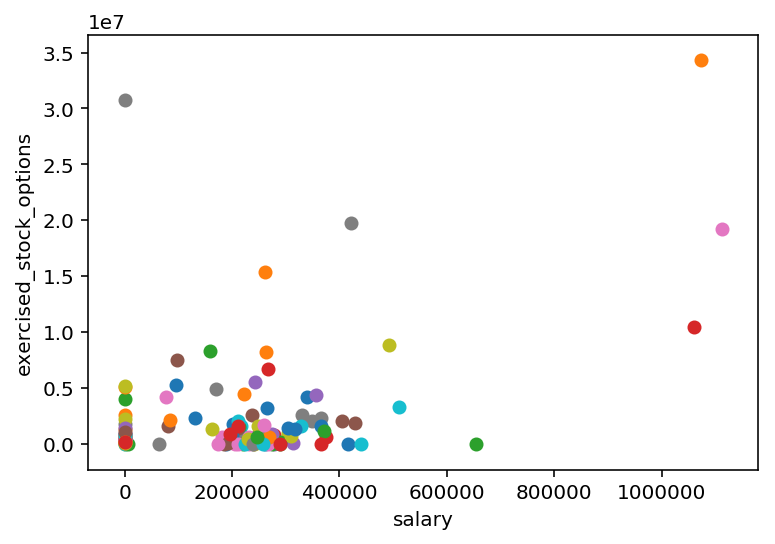

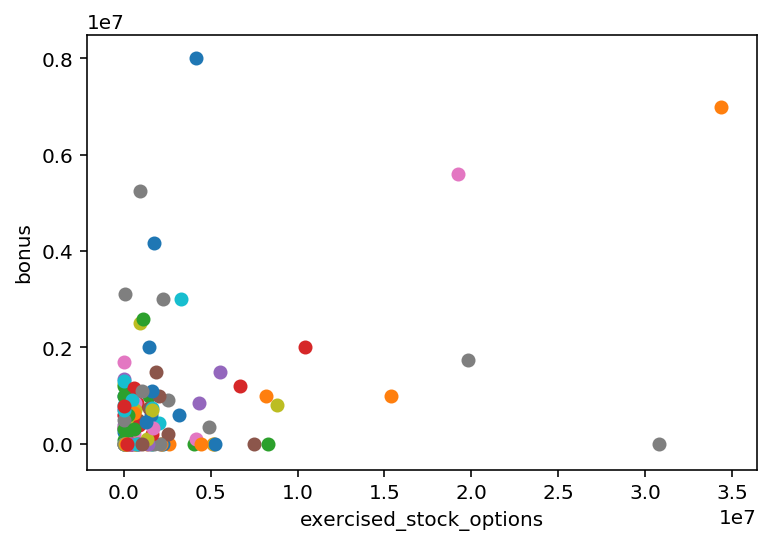

In [69]:
def draw_2features_scatter(X_id, Y_id):
    import matplotlib.pyplot as plt
    for point in features:
        X = point[X_id]
        Y = point[Y_id]
        plt.scatter( X, Y )
    plt.xlabel(features_list[1+X_id])
    plt.ylabel(features_list[1+Y_id])
    plt.show()

draw_2features_scatter(X_id=0, Y_id=2)
draw_2features_scatter(X_id=0, Y_id=1)
draw_2features_scatter(X_id=1, Y_id=2)

# Task 4: Try a varity of classifiers

In [9]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

clf_bayes = GaussianNB()


clf_DT = DecisionTreeClassifier()
param_DT = dict(reduce_dim__n_components=[2, 3], clf__min_samples_split=[2, 10, 40])

clf_SVM = SVC()
param_SVM = dict(reduce_dim__n_components=[2, 3], clf__kernel=['linear', 'sigmoid'])

In [10]:
### Use PCA(), GridSerchCV() to make model.
def make_model(clf, param_grid):
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    #构建管道
    estimators = [('reduce_dim', PCA()), ('clf', clf)]
    pipe = Pipeline(estimators)
    
    # 构建自动参数选择
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(pipe, param_grid=param_grid)
    
    return model

# Task 5: Tune your classifier

In [7]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# 构建自动参数选择
from time import time

t0 = time()
model = make_model(clf=clf_DT, param_grid=param_DT)
model.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t1 = time()
pred = model.predict(features_test)
print "testing time:", round(time()-t1, 3), "s"

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, labels_test)
print "ACC:{0}".format(acc)


training time: 0.447 s
testing time: 0.0 s
ACC:0.829268292683


In [8]:
model.best_params_

{'clf__min_samples_split': 10, 'reduce_dim__n_components': 3}

In [9]:
model.best_estimator_.named_steps['reduce_dim'].components_[0]

array([  2.29839566e-02,   9.91023736e-01,   1.31693796e-01,
        -6.15014586e-04,   2.42754902e-04,  -3.97017869e-10])

In [10]:
clf=model

# Task 6: Dump your classifier, dataset, and features_list

In [169]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

# * Use test.py to get scores

In [135]:
import tester as t

t.main()

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impu...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reduce_dim__n_components': [2, 3], 'clf__min_samples_split': [2, 10, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
	Accuracy: 0.85721	Precision: 0.50034	Recall: 0.36700	F1: 0.42342	F2: 0.38766
	Total predictions: 14000	True positives:  734	False positives:  733	False negatives: 1266	True negatives: 11267



# Try another Algorithm

## origin features & DT

In [19]:
features_list = ['poi','salary', 'exercised_stock_options', 'bonus', 'loan_advances','expenses']#'poi_message_percentage']
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# 构建自动参数选择
from time import time

t0 = time()
model = make_model(clf=clf_DT, param_grid=param_DT)
model.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t1 = time()
pred = model.predict(features_test)
print "testing time:", round(time()-t1, 3), "s"

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, labels_test)
print "ACC:{0}".format(acc)

model.best_params_

clf=model

dump_classifier_and_data(clf, my_dataset, features_list)

import tester as t
t.main()

training time: 0.133 s
testing time: 0.002 s
ACC:0.85
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impu...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reduce_dim__n_components': [2, 3], 'clf__min_samples_split': [2, 10, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
	Accuracy: 0.86443	Precision: 0.53576	Recall: 0.38200	F1: 0.44600	F2: 0.40526
	Total predictions: 14000	True positives:  764	False positives:  662	False negatives: 1236	True negatives: 11338



In [20]:
print model.best_estimator_.named_steps['reduce_dim'].components_
print model.best_estimator_.named_steps['clf'].feature_importances_ 

[[  1.07498471e-02   4.65153263e-01   7.56292661e-02   8.81927769e-01
    7.11946923e-04]
 [  4.74351932e-03   8.83489743e-01   2.19103724e-02  -4.67913781e-01
   -5.24706803e-05]
 [  8.02745506e-02  -5.52770830e-02   9.93577550e-01  -5.70333141e-02
    7.16194000e-03]]
[ 0.26762602  0.17144364  0.56093034]


## new features and DT

In [21]:
features_list = ['poi','salary', 'exercised_stock_options', 'bonus', 'loan_advances','expenses', 'poi_message_percentage']
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# 构建自动参数选择
from time import time

t0 = time()
model = make_model(clf=clf_DT, param_grid=param_DT)
model.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t1 = time()
pred = model.predict(features_test)
print "testing time:", round(time()-t1, 3), "s"

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, labels_test)
print "ACC:{0}".format(acc)

model.best_params_

clf=model

dump_classifier_and_data(clf, my_dataset, features_list)

import tester as t
t.main()

training time: 0.085 s
testing time: 0.0 s
ACC:0.829268292683
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impu...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reduce_dim__n_components': [2, 3], 'clf__min_samples_split': [2, 10, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
	Accuracy: 0.85621	Precision: 0.49554	Recall: 0.36100	F1: 0.41770	F2: 0.38173
	Total predictions: 14000	True positives:  722	False positives:  735	False negatives: 1278	True negatives: 11265



In [22]:
print model.best_estimator_.named_steps['reduce_dim'].components_
print model.best_estimator_.named_steps['clf'].feature_importances_ 

[[  2.29839566e-02   9.91023736e-01   1.31693796e-01  -6.15014586e-04
    2.42754902e-04  -3.97017869e-10]
 [  7.12487447e-02  -1.33015161e-01   9.88515384e-01  -4.26641458e-04
    8.23026111e-03   1.03104862e-08]
 [  9.87075628e-01  -1.30715391e-02  -7.34849264e-02   1.19731846e-01
    7.59940112e-02   4.72382506e-08]]
[ 0.29903148  0.70096852  0.        ]


## origin features and SVM

In [ ]:
features_list = ['poi','salary', 'exercised_stock_options', 'bonus', 'loan_advances','expenses']
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# 构建自动参数选择
from time import time

t0 = time()
model = make_model(clf=clf_SVM, param_grid=param_SVM)
model.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t1 = time()
pred = model.predict(features_test)
print "testing time:", round(time()-t1, 3), "s"

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, labels_test)
print "ACC:{0}".format(acc)

model.best_params_

clf=model

dump_classifier_and_data(clf, my_dataset, features_list)

import tester as t
t.main()